Progetto: Tentativo di rimuovere eventuali rumori da tracce (mono) registrate mediante un giradischi

In [319]:
# Import
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import IPython
import warnings

import librosa as lb # Libreria per sound-processing
import soundfile as sf # Libreria per esportare .wav

In [320]:
# Costanti
FS = 48000 # frequenza di campionamento dei file del dataSet
NOISE_SECTION = 5 # Ultimi secondi del brano = rumore puro (per dominio)
N_FFT = 2048 # Dimensione della finestra della STFT
HL = 512 # Overlap-Add, dopo aver analizzato i primi 2048 campioni non passo ai 2048 successivi 
         # ma ai 2048/4 successivi (512), necessario per non creare artefatti (sovrapposizione)
         
track_wav="../dataSet/tracks/temp.wav"
noise_wav="../dataSet/noise.wav"
OUTPUT_SOTTSPETTR="../dataSet/output/outputSS.wav"
OUTPUT_SOGLIATURA="../dataSet/output/outputS.wav"
OUTPUT_NORM = "../dataSet/output/outputN.wav"

Partiamo analizzando il fenomeno rumoroso in se, ottenuto registrando l'output dell'amplificatore senza alcun brano in riproduzione

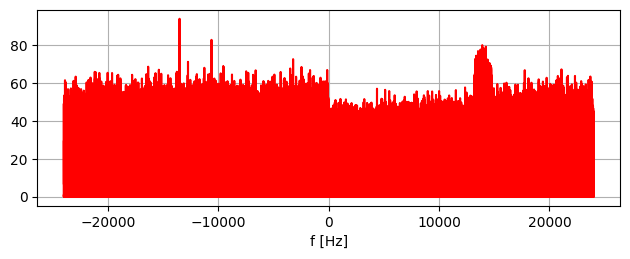

In [321]:
# Analizziamo il rumore
nfs, noise = wav.read(noise_wav) # creo l'array

N = len(noise) # Lunghezza dell'array noise (dei campioni)

# Proviamo a calcolare la trasformata di Fourier con la funzione np.fft.fft di numpy
nf = nfs/N * np.arange(N) # asse delle frequenze
FFT_noise = np.fft.fft(noise)/N # DFT dell'intero array
noise_freq = np.fft.fftfreq(N, 1/nfs) # Vettore delle frequenze

plt.subplot(2,1,2)
plt.plot(noise_freq,np.abs(FFT_noise),'-r',label="$X_f(f)$")
plt.xlabel('f [Hz]')
plt.tight_layout()
plt.grid()

L'approccio con una singola Trasformata di Fourier (FFT) sull'intero brano è inadatto, perché tratta il segnale come statico. Così facendo, si ottiene uno spettro che ha un'altissima risoluzione in frequenza, ma perdiamo completamente i riferimenti temporali. Si perde tutta l'informazione su quando una frequenza appare.

Dato che la musica è un segnale non-stazionario (che evolve continuamente), dobbiamo passare a una Short-Time Fourier Transform (STFT). Analizzando il segnale a fette cosi' mantenendo il legame frequenza-tempo

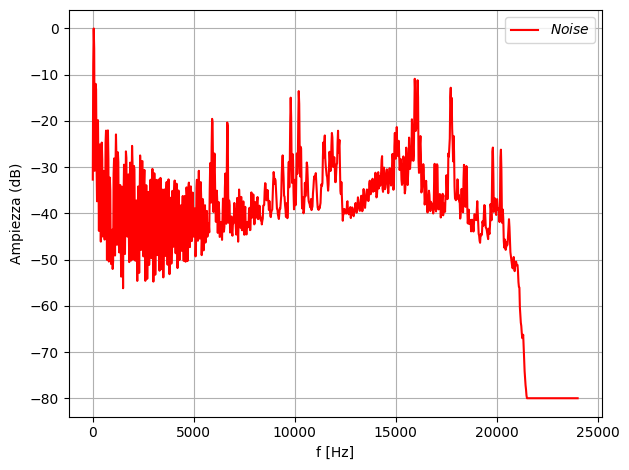

In [322]:
noise, sr = lb.load(noise_wav, sr=FS) # come per wav.read, ma crea un array di Float piuttosto che di Interi con Frequenza di Campionamento pari a FS = 48000Hz
STFT_noise = lb.stft(noise, n_fft = N_FFT, hop_length=HL) # eseguo la trasformata di Fourier (STFT) con le finestre prescelte

noise_mod = np.abs(STFT_noise) # considero il modulo della trasformata ossia una matrice bidimensionale (spettrogramma frequenza-tempo)
noise_profile = np.mean(noise_mod, axis=1) # esegue la media lungo l'asse 1 (tempo), quindi creando un vettore di intensita' (ampiezze)
f = lb.fft_frequencies(sr=sr, n_fft=N_FFT) # asse delle frequenze da mettere a confronto con il profilo (lo definisco una sola volta)
noise_db = lb.amplitude_to_db(noise_profile, ref=np.max) # converte i float delle frequenze dell'array noise in decibel

plt.plot(f, noise_db,'-r',label="$Noise$")
plt.xlabel('f [Hz]')
plt.ylabel('Ampiezza (dB)')
plt.legend()
plt.tight_layout()
plt.grid()

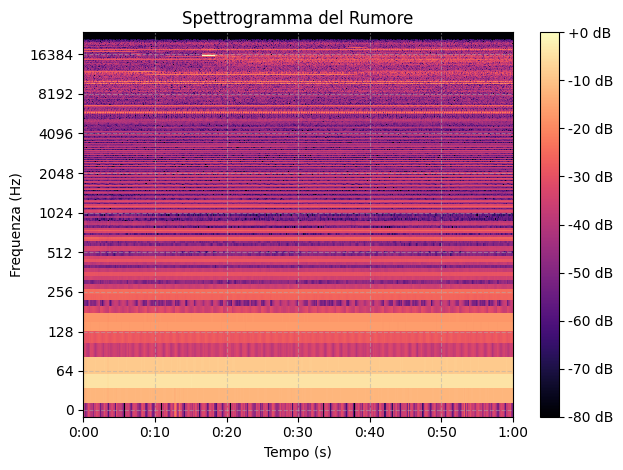

In [323]:
# Spettrogramma del Rumore:
noise_mod_db = lb.amplitude_to_db(noise_mod, ref=np.max)
lb.display.specshow(noise_mod_db, sr=sr, hop_length=HL, x_axis='time', y_axis='log')

plt.colorbar(format='%+2.0f dB') 
plt.title('Spettrogramma del Rumore')
plt.xlabel('Tempo (s)')
plt.ylabel('Frequenza (Hz)')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Notiamo dallo spettrogramma come i rumori si annidano anche nelle frequenze piu' basse.

Ora procediamo con l'analisi del brano rumoroso in se

In [324]:
# Riproduciamo il brano di partenza contenente il rumore
IPython.display.Audio(track_wav)

In [325]:
# Analizziamo il Brano
track, sr = lb.load(track_wav, sr=FS) # Questo comando carica il segnale e restituisce : segnale (array float), frequenza_campionamento
STFT_track = lb.stft(track, n_fft = N_FFT, hop_length=HL) # eseguo la trasformata di Fourier (STFT) con le finestre prescelte

track_mod = np.abs(STFT_track) # considero il modulo della trasformata (freq, time) 
track_profile = np.mean(track_mod, axis=1) # esegue la media lungo l'asse 1 (tempo), quindi creando un vettore di intensita' (ampiezze)

track_db = lb.amplitude_to_db(track_profile, ref=np.max) # converte i float delle frequenze dell'array noise in decibel

/var/folders/jg/37l_l3y5767gf664zsdvms5r0000gn/T/ipykernel_2342/679918296.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  track, sr = lb.load(track_wav, sr=FS) # Questo comando carica il segnale e restituisce : segnale (array float), frequenza_campionamento
/Users/filippob04/venvs/py313/lib/python3.13/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


EOFError: 

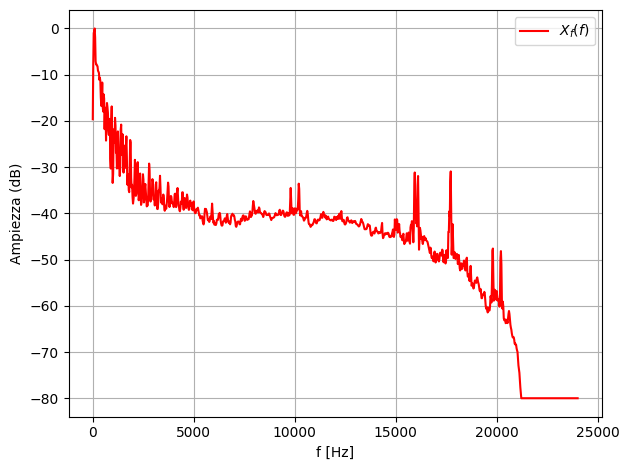

In [ ]:
plt.plot(f, track_db,'-r',label="$X_f(f)$")
plt.xlabel('f [Hz]')
plt.ylabel('Ampiezza (dB)')
plt.legend()
plt.tight_layout()
plt.grid()

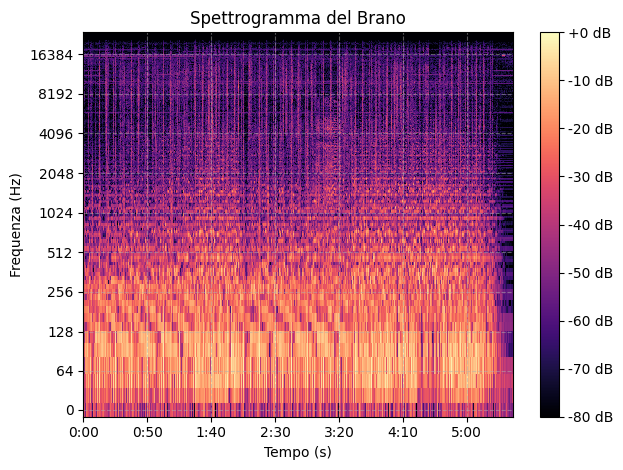

In [ ]:
# Spettrogramma del Brano:
track_mod_db = lb.amplitude_to_db(track_mod, ref=np.max) # considero la trasformazione in decibel della matrice 2D che definisce lo spettrogramma
lb.display.specshow(track_mod_db, sr=sr, hop_length=HL, x_axis='time', y_axis='log')

plt.colorbar(format='%+2.0f dB') 
plt.title('Spettrogramma del Brano')
plt.xlabel('Tempo (s)')
plt.ylabel('Frequenza (Hz)')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Possiamo scegliere fra due Approcci, o utilizziamo il rumore in se come riferimento, rischiando di avere registrazioni effettuate in condizioni diverse oppure, per assicurarci che Rumore e Brano siano stati registrati con gli stessi parametri, aggiungiamo la condizione che i file in input terminino con dei secondi di rumore puro cosi' saremo in grado di estrapolare tale sezione assicurandoci cosi' di avere la stessa base di partenza (determinata dall'amplificatore (volume))

In [ ]:
# Estraiamo il rumore dagli ultimi NOISE_SECTION secondi del brano
noise_samples = int(NOISE_SECTION * sr) # numero di campioni (secondi * frequenza)

# Dividiamo il brano in due: Musica e Rumore Finale
noise_part = track[-noise_samples:]
music_part = track[:-noise_samples]

# Eseguiamo STFT del brano e del Rumore
STFT_track = lb.stft(music_part, n_fft=N_FFT, hop_length=HL)
STFT_noise = lb.stft(noise_part, n_fft = N_FFT, hop_length=HL) 

In [ ]:
track_mod = np.abs(STFT_track) # calcoliamo il modulo del brano (matrice 2D tempo-frequenza)
track_profile = np.mean(track_mod, axis=1) # esegue la media lungo l'asse 1 (tempo), quindi creando un vettore di intensita' (ampiezze)
noise_mod = np.abs(STFT_noise) # idem per rumore
noise_profile = np.mean(noise_mod, axis=1) # idem per rumore

ref_value = max(np.max(track_profile), np.max(noise_profile)) # valore per normalizzare le due tracce 

noise_db = lb.amplitude_to_db(noise_profile, ref=ref_value) # converte le ampiezze dell'array in decibel
track_db = lb.amplitude_to_db(track_profile, ref=ref_value) # idem per traccia

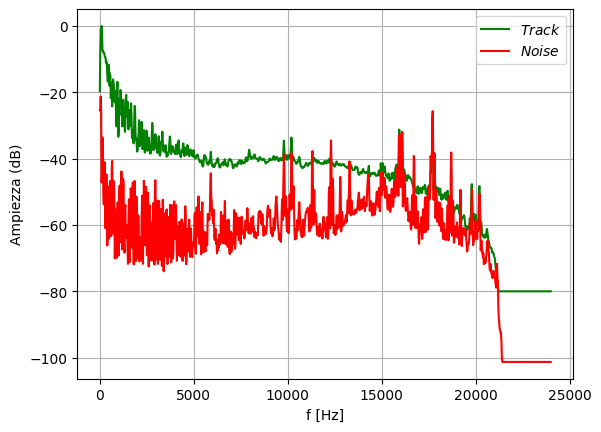

In [ ]:
plt.plot(f, track_db,'-g', label="$Track$")
plt.plot(f, noise_db,'-r', label="$Noise$")

plt.xlabel('f [Hz]')
plt.ylabel('Ampiezza (dB)')

plt.legend(loc="upper right")
plt.grid()

con questa vista possiamo notare un problema fondamentale, il rumore vive nello stesso range di frequenze del brano dunque l'applicazione di un semplice filtro di sogliatura rimuoverebbe gran parte dei dettagli del brano rendendolo irriconoscibile.

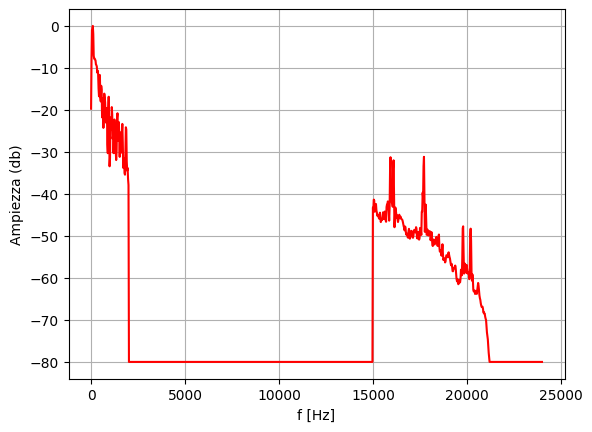

In [ ]:
# Esempio di Sogliatura
thresh_h = 15000
thresh_l = 2000

# find all the indices corresponding to frequencies greather than a threshold 
idx = np.argwhere((np.abs(f) < thresh_h) & (np.abs(f) > thresh_l))
STFT_cut=np.copy(STFT_track)
STFT_cut[idx, :] = 0 # imposta l'ampiezza dei valori a zero

track_filt = np.mean(np.abs(STFT_cut), axis=1)
track_filt_db = lb.amplitude_to_db(track_filt, ref=np.max)

plt.plot(f, track_filt_db, '-r', label=f"Spettro Filtrato (- ({thresh_l} < {thresh_h}) Hz)")
plt.xlabel('f [Hz]')
plt.ylabel('Ampiezza (db)')

plt.grid()

In [ ]:
track_clean_filtered = lb.istft(STFT_cut, hop_length=HL) # Torniamo nel dominio del tempo
# Output
sf.write(OUTPUT_SOGLIATURA, track_clean_filtered, sr, subtype='PCM_24')

Evidentemente quindi non e' possibile eseguire una semplice sogliatura per rimuovere la parte rumorosa.

Procediamo con un primo tentativo di riduzione del Rumore tramite l'operazione di sottrazione spettrale, ossia rimuoviamo (operando su matrici 2D (tempo-frequenza) il rumore, ove presente. Importante notare che in eventuali zone di silenzio o dove noise > segnale il risultato sarebbe negativo percio' in tal caso lo impostiamo a zero)

In [ ]:
# Procediamo con un primo tentativo di riduzione del Rumore
profile_expanded = noise_profile[:, np.newaxis] # Passiamo da un vettore 1D (medie ampiezze rumorose) ad una versione 2D (con le dimensioni di track_mod)
# Sottrazione Spettrale ossia, rimuovo dal brano il vettore delle frequenze dove noise > track (ampiezza)
mod_clean = np.maximum(track_mod - profile_expanded, 0) # Dove era presente noise > track il rumore viene ridotto (0 indica il floor, x < 0 = 0)

track_phase = np.angle(STFT_track) # Otteniamo la fase (theta) del brano
STFT_clean = mod_clean * np.exp(1j * track_phase) # Eulero e^jθ

track_clean = lb.istft(STFT_clean, hop_length=HL) # Torniamo nel dominio del tempo con la trasformata inversa

# Output
sf.write(OUTPUT_SOTTSPETTR, track_clean, sr, subtype='PCM_24')

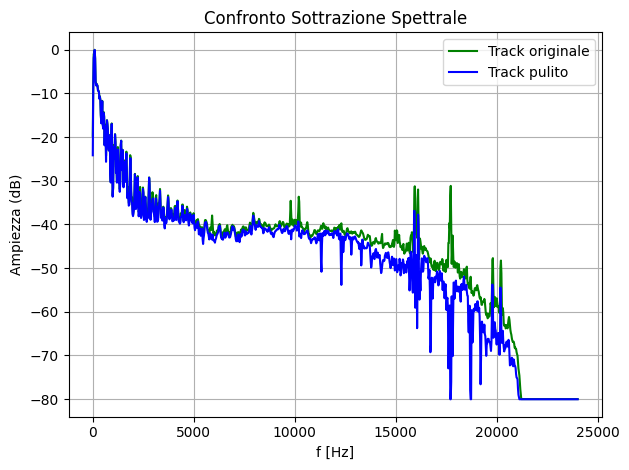

In [ ]:
# Analisi spettrale del segnale pulito
clean_profile = np.mean(mod_clean, axis=1) # esegue la media lungo l'asse 1 (tempo), quindi creando un vettore di intensita' (ampiezze)

f = lb.fft_frequencies(sr=sr, n_fft=N_FFT)
ref_value = max(np.max(track_profile), np.max(clean_profile)) # valore per normalizzare le due tracce

clean_db = lb.amplitude_to_db(clean_profile, ref=ref_value)

# Plot confronto
plt.figure()
plt.plot(f, track_db, '-g', label='Track originale')
plt.plot(f, clean_db, '-b', label='Track pulito')
plt.xlabel('f [Hz]')
plt.ylabel('Ampiezza (dB)')
plt.title('Confronto Sottrazione Spettrale')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Notiamo come il segnale pulito pressocche' segua quello originale, con la piu' grande differenza osservabile fra i 15000Hz - 17500Hz dove risiedeva anche la gran parte del rumore udibile

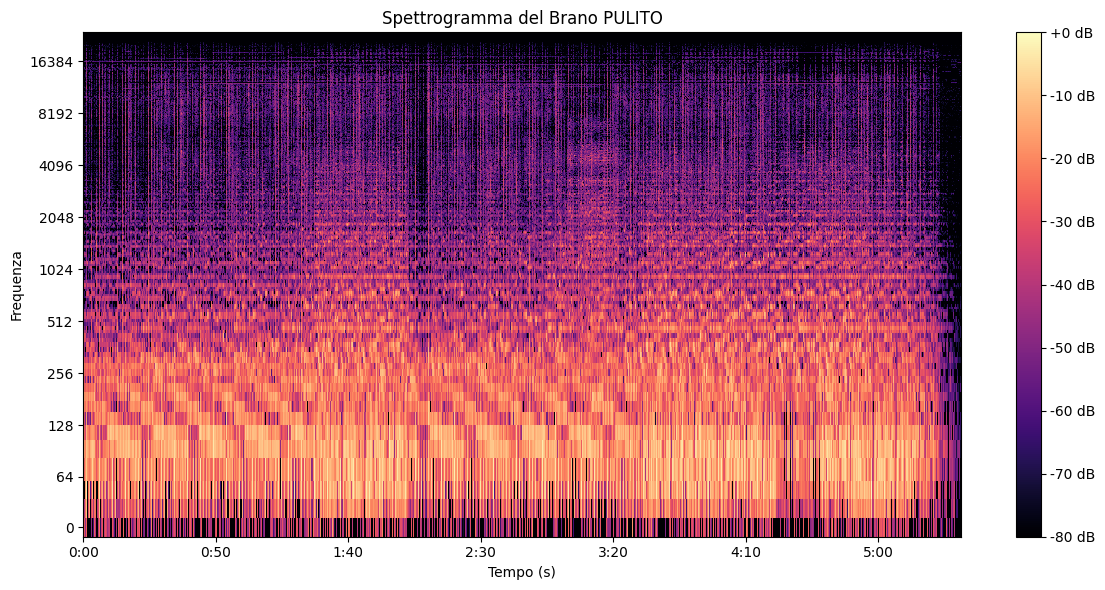

In [ ]:
clean_mod_db = lb.amplitude_to_db(mod_clean, ref=np.max)
plt.figure(figsize=(12, 6))

lb.display.specshow(clean_mod_db, sr=sr, hop_length=HL, x_axis='time', y_axis='log')

plt.colorbar(format='%+2.0f dB')
plt.title('Spettrogramma del Brano PULITO')
plt.xlabel('Tempo (s)')
plt.ylabel('Frequenza')
plt.tight_layout()
plt.show()

Ascoltando il brano o analizzando il grafico ci rendiamo rapidamente conto che il volume originale risulta ribassato (banalmente si tratta di una sottrazione alla fine dei conti) dunque dobbiamo sottoporlo ad un processo di normalizzazione.
Tale processo consiste nel trovare il sample massimo, portarlo a +- 1 dB ed aggiustare gli altri campioni di conseguenza

In [ ]:
# Normalizzazione
peak = np.max(np.abs(track_clean)) # eseguo il valore assoluto del segnale pulito per trovare il valore massimo (nel dominio del tempo)
target_amp = 1 

gain = target_amp/peak # calcolo il fattore di guadagno ossia di quanto devo incrementare la traccia (prodotto scalare)
track_norm = track_clean * gain

sf.write(OUTPUT_NORM, track_norm, sr, subtype='PCM_24') # output

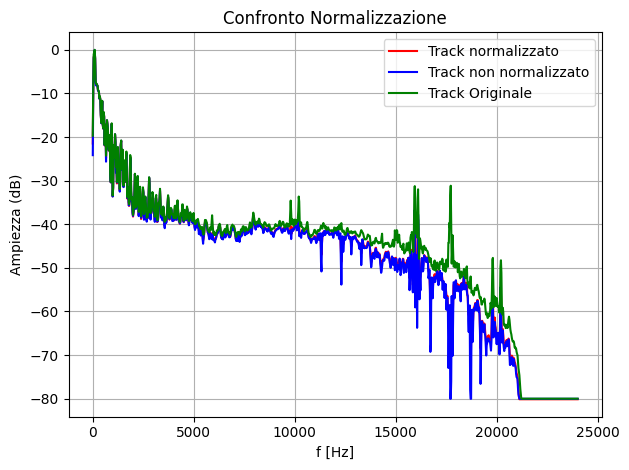

In [ ]:
STFT_norm = lb.stft(track_norm, n_fft = N_FFT, hop_length=HL) # andiamo nel dominio delel frequenze
mod_norm = np.abs(STFT_norm) # calcoliamo il modulo (tempo-frequenza)
norm_profile = np.mean(mod_norm, axis=1) # esegue la media lungo l'asse 1 (tempo), quindi creando un vettore di intensita' (ampiezze)
ref_value = max(np.max(norm_profile), np.max(track_profile), np.max(clean_profile)) # valore per normalizzare le due tracce
norm_db = lb.amplitude_to_db(norm_profile, ref=ref_value)

# Plot confronto 
plt.figure()
plt.plot(f, norm_db, '-r', label='Track normalizzato')
plt.plot(f, clean_db, '-b', label='Track non normalizzato')
plt.plot(f, track_db, '-g', label='Track Originale')
plt.xlabel('f [Hz]')
plt.ylabel('Ampiezza (dB)')
plt.title('Confronto Normalizzazione')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Provando ad applicare in piu' iterazioni questo filtro su se stesso otteniamo di certo brani con meno rumore ma allo stesso tempo riceviamo suoni piu' ovattati e perdiamo alcuni dettagli.